# Вычислительное музыковедение: Модели и методы Music Data Mining

## Лабораторная работа №4. MIR системы

### Автоматическая музыкальная транскрипция

Полезная литература:

https://arxiv.org/pdf/2108.10689.pdf

https://gitlab.com/BojanSof/scorpiano

Классический пайплайн для АМТ в ситуации одноголосой (monophonic) записи

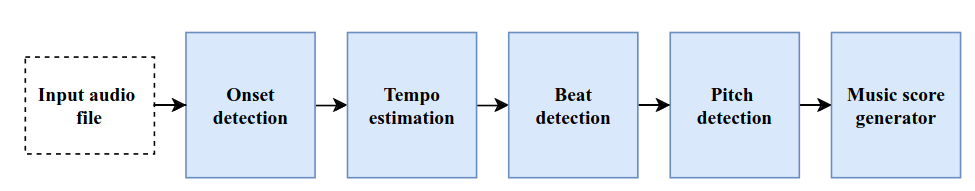

###### **Задание №1 (1 балл):** Подготовка файла и получение музыкальной транскрипции.


Нужно выбрать файл в формате wav с которым будете работать. Данный файл должен соответствовать следующим условиям:
1. Monophonic
2. Запись фортепиано
3. Формат wav

Для этого вы можете:
1. Найти подходящий файл в интернете
2. Записать свою игру на фортепиано
3. Воспользоваться сервисом https://onlinesequencer.net/ : набрать нужную мелодию, выбрать инструмент и экспортировать как wav.

In [3]:
import librosa
from IPython.display import Audio

filename = "PrecrasnoyeDalyoko.wav" # ВАШ файл

signal, sr = librosa.load(filename, sr=44100)
Audio(signal, rate=sr)

#### Onset detection

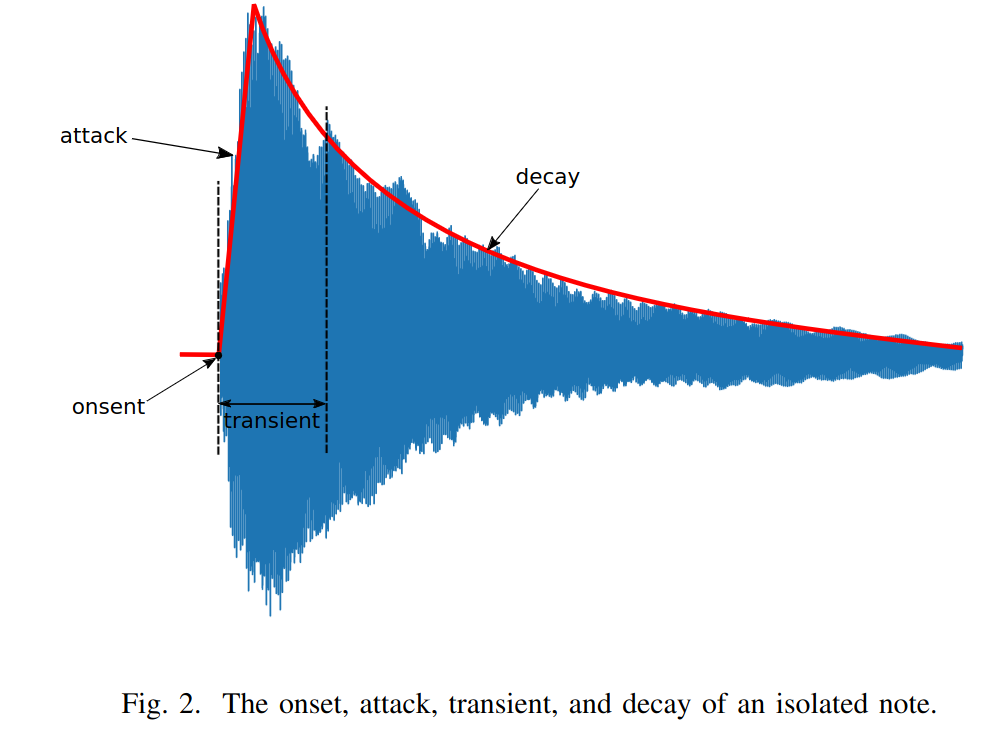

##### Самостоятельно реализованный алгоритм

###### **Задание №2 (4 балла):** реализовать предложенный алгоритм Onset Detection.

Этап 1. Вычисление local energy function.

$$ E[n]=\sum_{m=-M}^{M} |x[n+m]*w[m]|^2 = \sum_{m \in Z}|x[m]*w[m-n]|^2 = x^2[n]*w^2[n]$$

где $w$ - это колоковидная оконная функция длиной 2M+1, например, Hann window

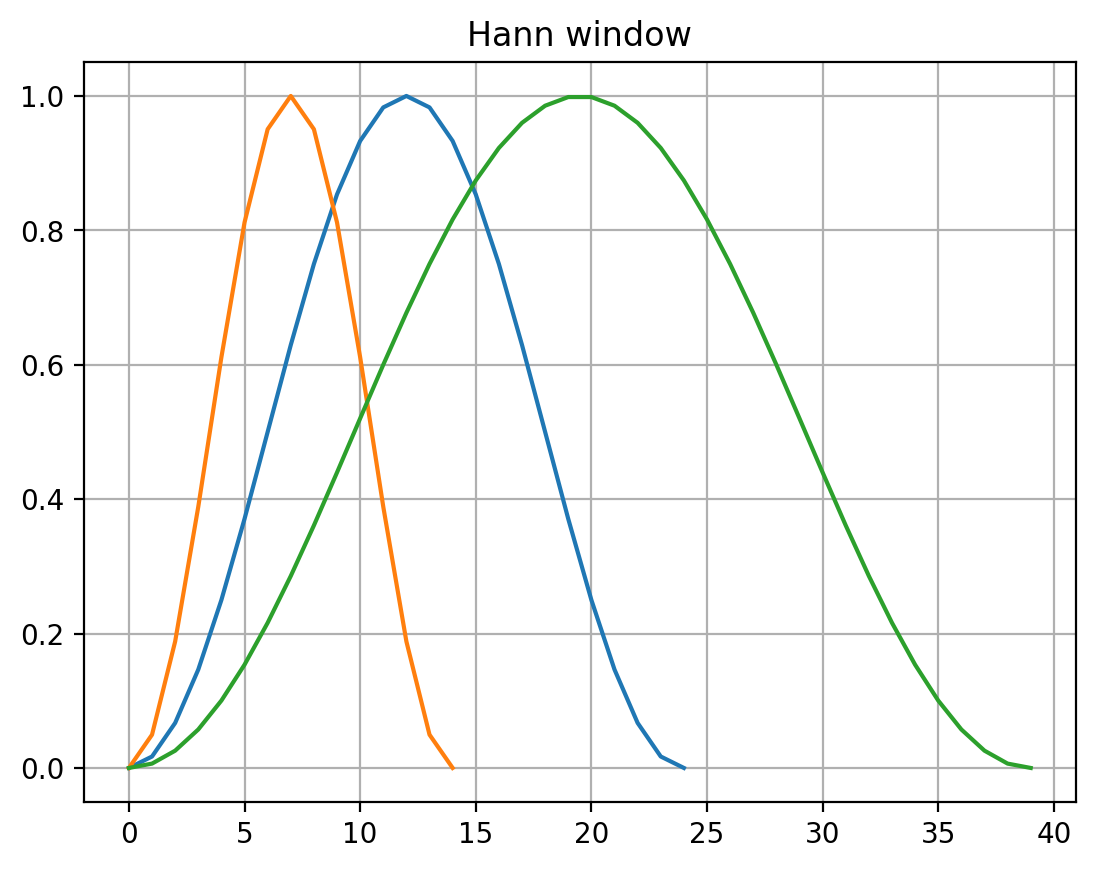

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.hanning(25))
plt.plot(np.hanning(15))
plt.plot(np.hanning(40))
plt.grid()
plt.title("Hann window")
plt.show()

In [5]:
def local_energy_function(
    signal,             # сам сигнал
    len_wind_in_ms=50,  # длина окна в милисекундах
    sr=44100,           # частота дискретизации
):
  # Ищем длину окна в отсчетах
  ticks = len_wind_in_ms / 1000 * sr
  M = int(ticks // 2)
  # Инициализируем окно
  w = np.hanning(2 * M + 1)
  # Подготавливаем список для результата
  energy = np.zeros_like(signal, dtype=float)
  # Добавляем M нулей в начало и конец, чтобы длина energy на выходе была равна длине signal
  padded_signal = np.pad(signal, M, mode='constant', constant_values=0)
  # Проходим маской по сигналу
  for n in range(M, len(padded_signal) - M):
      # Считаем энергию
      local_sum = np.sum((padded_signal[n - M:n + M + 1] * w) ** 2)
      # Кладем энергию в список
      energy[n - M] = local_sum
  return energy

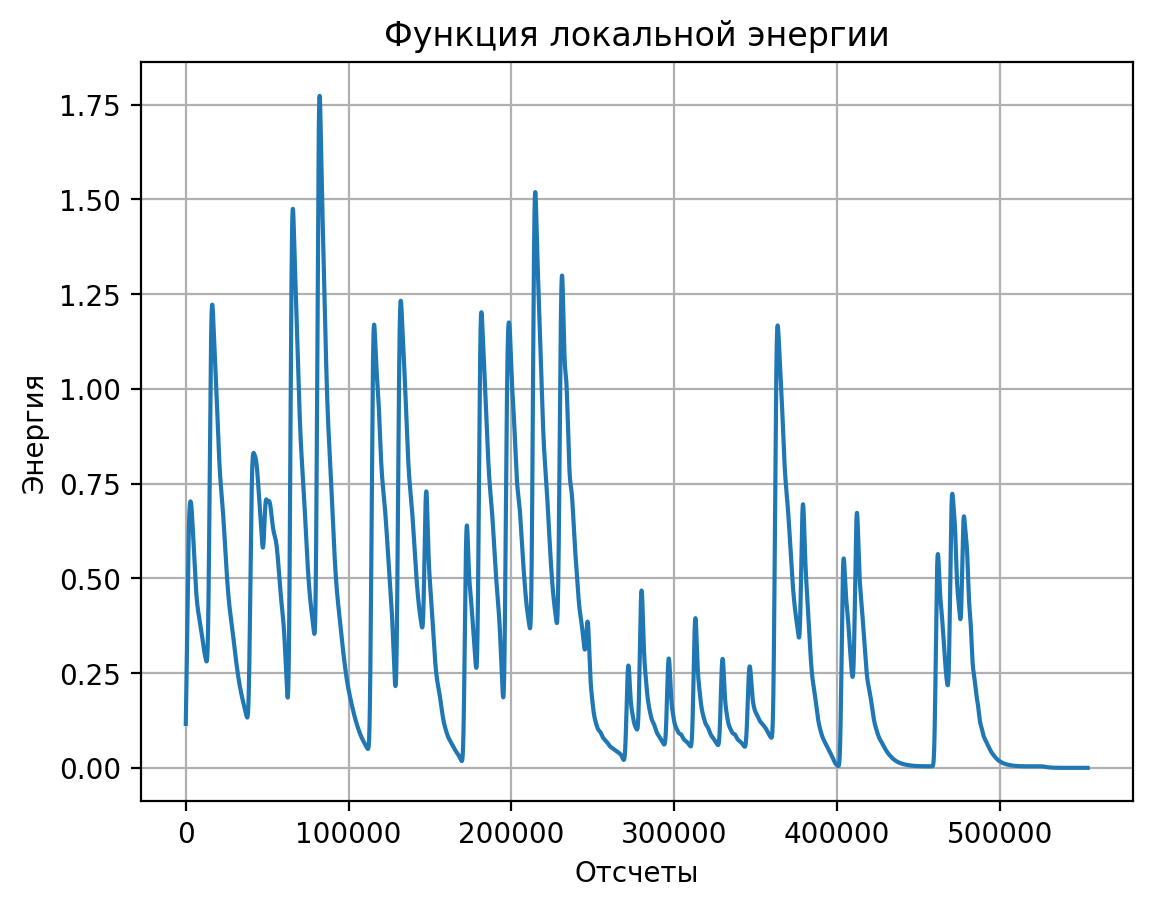

In [6]:
energy = local_energy_function(signal, len_wind_in_ms=120, sr=sr)
plt.plot(energy)
plt.grid()
plt.title("Функция локальной энергии")
plt.xlabel("Отсчеты")
plt.ylabel("Энергия")
plt.show()

Этап 2. Logarithmic compression

$$ E_\gamma[n] = log (1 + \gamma * E[n])$$

In [7]:
def log_compression(energy, gamma):
  return np.log(1 + gamma * energy)

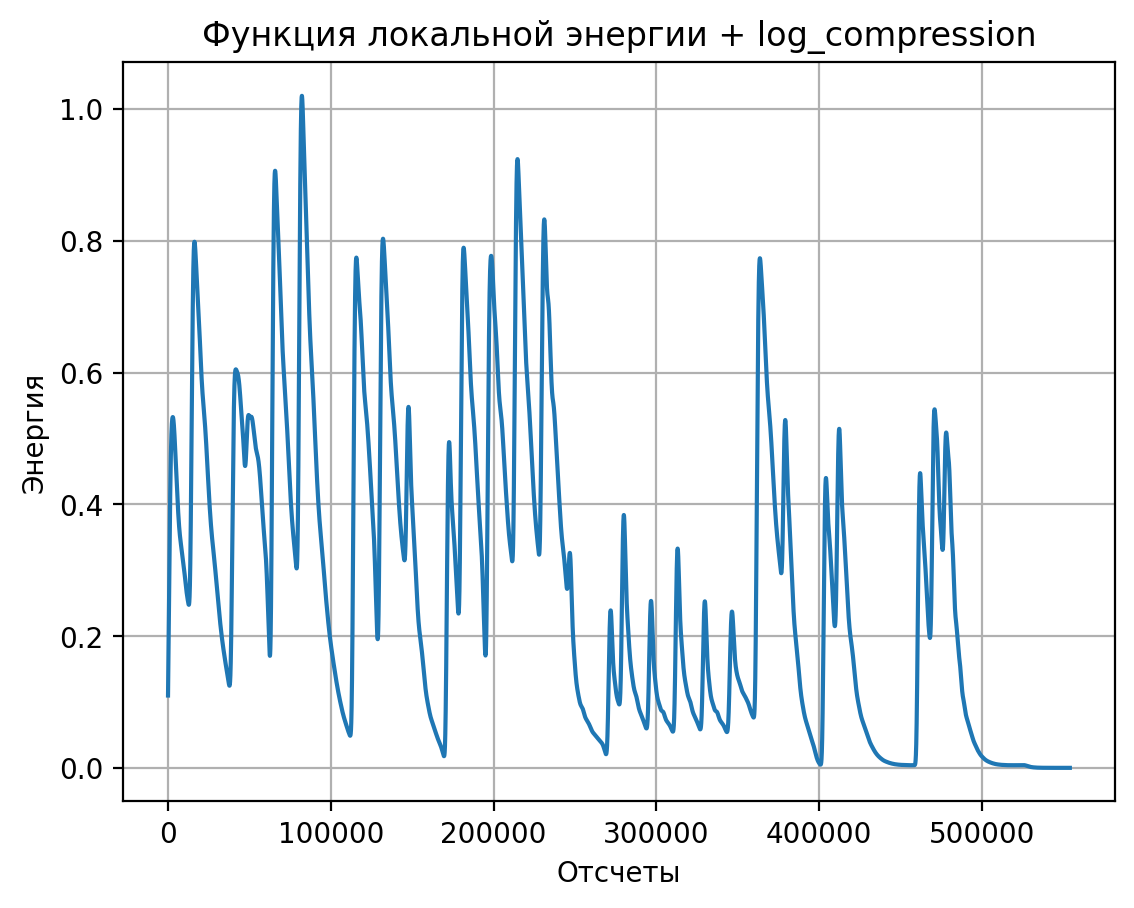

In [8]:
log_energy = log_compression(energy, gamma=1) # Поиграйтесь с параметрами!!! Или пропустите этап, посмотрите как все пойдет
plt.plot(log_energy)
plt.grid()
plt.title("Функция локальной энергии + log_compression")
plt.xlabel("Отсчеты")
plt.ylabel("Энергия")
plt.show()

Этап 3. Возьмем первую производную, чтобы получить разницу энергии. Как мы помним из курса математического анализа, численно можем апроксимировать, взяв разницу между подряд идущими значениями энергии

In [9]:
def first_derivative(log_energy):
  return np.diff(log_energy)

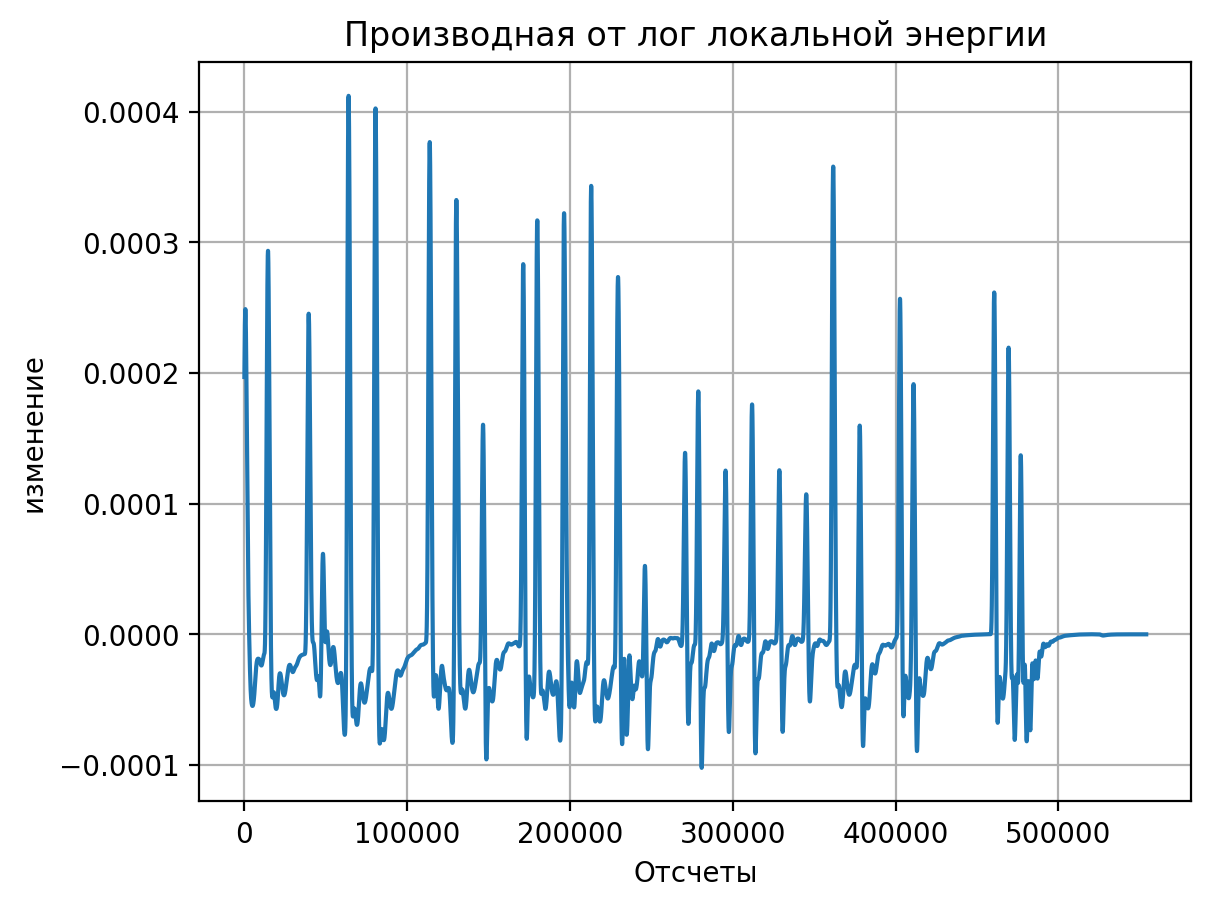

In [10]:
derv = first_derivative(log_energy)
plt.plot(derv)
plt.grid()
plt.title("Производная от лог локальной энергии")
plt.xlabel("Отсчеты")
plt.ylabel("изменение")
plt.show()

Этап 4. Применение half-wave rectification function, так как нас интересует искульчительно резкие скачки энергии

In [11]:
def half_wave_rectification(derivative):
    half_waved = derivative.copy()
    half_waved[half_waved < 0] = 0
    return half_waved

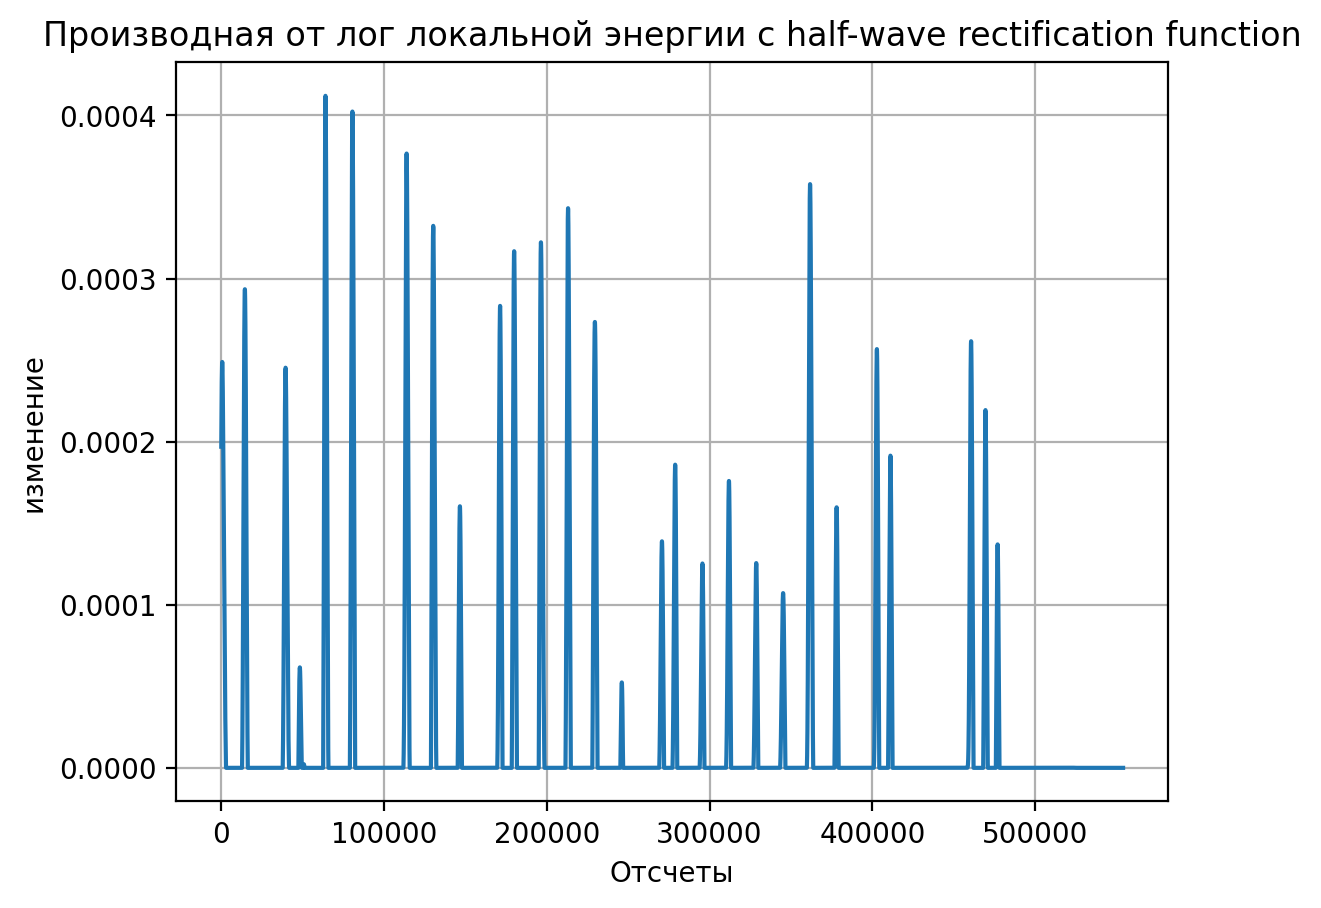

In [12]:
derv_with_half_wave = half_wave_rectification(derv)
plt.plot(derv_with_half_wave)
plt.grid()
plt.title("Производная от лог локальной энергии c half-wave rectification function")
plt.xlabel("Отсчеты")
plt.ylabel("изменение")
plt.show()

Этап 5. Определение максимумов


In [13]:
def get_all_local_maximas(data):
    derv = np.diff(data)
    left_positive = np.hstack([[0], derv]) > 0
    right_negative = np.hstack([derv, [0]]) < 0
    return np.where(left_positive & right_negative)[0]

Функция для выбора наибольших значений из промежутка

In [14]:
def apply_time_threshold(data, maximas, time_thd, sr=44100):
    maximas_start_ind = 0
    step_size = int(np.floor(time_thd * sr))
    filtered = []
    for window_start in range(0, len(data), step_size):
        # if maximas_start_ind >= len(maximas):
        #     break
        window_end = window_start + step_size
        maximas_end_ind = get_maximas_end_ind(maximas, maximas_start_ind, window_end)
        if maximas_end_ind - maximas_start_ind > 0:
            max_maxima = get_max_maxima_from_range(data, maximas, maximas_start_ind, maximas_end_ind)
            filtered.append(max_maxima)
        maximas_start_ind = maximas_end_ind
    return np.array(filtered)

def get_maximas_end_ind(maximas, maximas_start_ind, window_end):
    maximas_end_ind = maximas_start_ind # не включительно
    while maximas_end_ind < len(maximas) and maximas[maximas_end_ind] < window_end:
        maximas_end_ind += 1
    return maximas_end_ind


def get_max_maxima_from_range(data, maximas,maximas_start_ind, maximas_end_ind):
    values =data[maximas]
    window_values = values[maximas_start_ind: maximas_end_ind]
    max_maxima_ind = np.argmax(window_values) + maximas_start_ind
    return maximas[max_maxima_ind]

Функция для фильтра по амплитуде

In [15]:
def apply_ampl_threshold(data, maximas, ampl_thd):
    ampl_mask = data[maximas] >= ampl_thd
    filtered = maximas[ampl_mask]
    return filtered

Протестируем

Максимумы после фильтрации по времени: [1 5]
Максимумы после фильтрации по амплитуде и времени: [5]


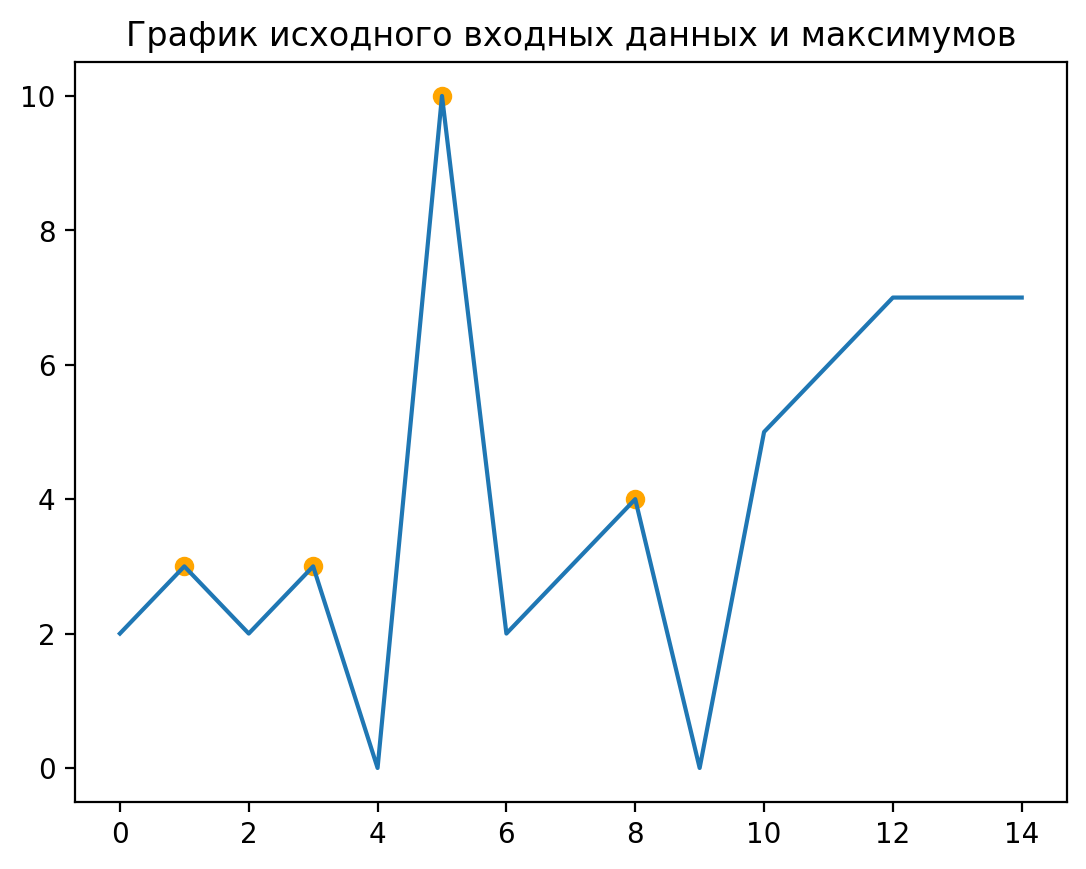

In [16]:
test_arr = np.array([2, 3, 2, 3, 0,
                     10, 2, 3, 4, 0,
                     5, 6, 7, 7, 7])
maximas = get_all_local_maximas(test_arr)
plt.plot(test_arr)
plt.scatter(maximas, test_arr[maximas], c='orange')
after_time = apply_time_threshold(test_arr, maximas, 5, 1)
plt.title('График исходного входных данных и максимумов')
print(f'Максимумы после фильтрации по времени: {after_time}')
print(f'Максимумы после фильтрации по амплитуде и времени: {apply_ampl_threshold(test_arr, after_time, 4)}')

Соберем все в одну функцию

In [17]:
def get_maxima(data, ampl_thd, time_thd, sr=44100):
    maximas = get_all_local_maximas(data)
    maximas = apply_time_threshold(data, maximas, time_thd, sr)
    maximas = apply_ampl_threshold(data, maximas, ampl_thd)
    return maximas

Проверим результат

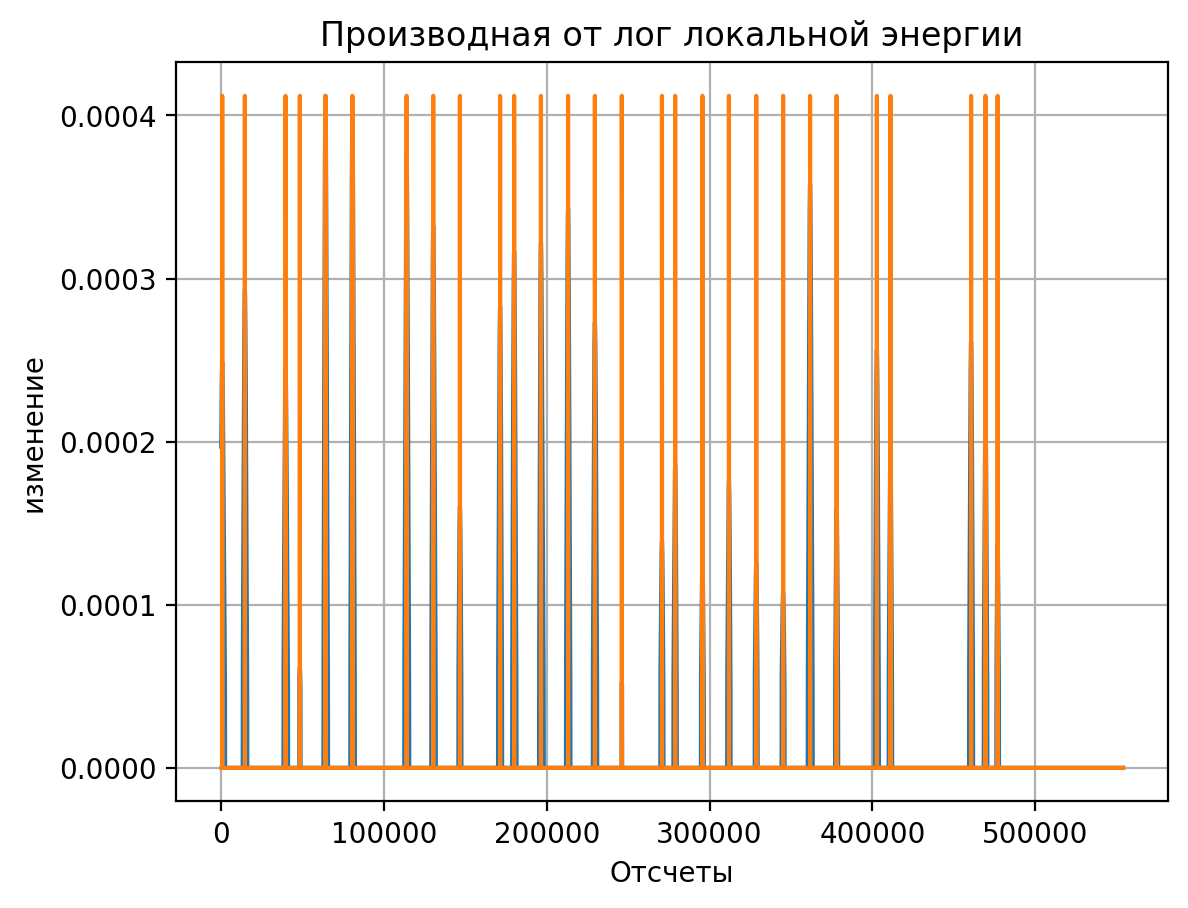

In [18]:
ampl_threshold = 0.00005
time_threshold = 0.15 # [s]

data_ = np.zeros(derv_with_half_wave.size)

maximas = get_maxima(derv_with_half_wave.copy(), ampl_threshold, time_threshold, sr)
for elem in maximas:
    data_[elem] = np.max(derv_with_half_wave)


plt.plot(np.where(derv_with_half_wave > ampl_threshold, derv_with_half_wave, 0))
plt.plot(data_)
plt.grid()
plt.title("Производная от лог локальной энергии")
plt.xlabel("Отсчеты")
plt.ylabel("изменение")
plt.show()

In [19]:
my_time_onset = []
for max_ in sorted(maximas):
  my_time_onset.append(max_ / sr)
print(my_time_onset)
clicks = librosa.clicks(times=my_time_onset, sr=sr, length=len(signal))
Audio( signal + clicks, rate=sr)

[0.013219954648526077, 0.3287301587301587, 0.8958956916099773, 1.0945351473922902, 1.4513605442176871, 1.826780045351474, 2.581791383219955, 2.9526984126984126, 3.3243990929705216, 3.8840362811791382, 4.079659863945579, 4.453151927437641, 4.830884353741497, 5.204761904761905, 5.579637188208617, 6.1388208616780044, 6.322925170068027, 6.702925170068027, 7.072108843537415, 7.452222222222222, 7.826621315192744, 8.2021768707483, 8.572131519274377, 9.13297052154195, 9.321678004535148, 10.445238095238095, 10.645691609977325, 10.814829931972788]


##### Onset detection in librosa

Документация: https://librosa.org/doc/main/generated/librosa.onset.onset_detect.html

In [20]:
librosa_onset_times = librosa.onset.onset_detect(y=signal, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1, units='time')
print(librosa_onset_times)

[ 0.03482993  0.33668934  0.89396825  1.09133787  1.46285714  1.83437642
  2.58902494  2.96054422  3.33206349  3.90095238  4.08671202  4.45823129
  4.84136054  5.21287982  5.58439909  6.15328798  6.33904762  6.71056689
  7.09369615  7.46521542  7.83673469  8.20825397  8.59138322  9.14866213
  9.33442177 10.46058957 10.64634921 10.83210884]


In [21]:
clicks = librosa.clicks(times=librosa_onset_times, sr=sr, length=len(signal))
Audio(signal + clicks, rate=sr)

Сравним результат с librosa

In [22]:
my_time_onset

[0.013219954648526077,
 0.3287301587301587,
 0.8958956916099773,
 1.0945351473922902,
 1.4513605442176871,
 1.826780045351474,
 2.581791383219955,
 2.9526984126984126,
 3.3243990929705216,
 3.8840362811791382,
 4.079659863945579,
 4.453151927437641,
 4.830884353741497,
 5.204761904761905,
 5.579637188208617,
 6.1388208616780044,
 6.322925170068027,
 6.702925170068027,
 7.072108843537415,
 7.452222222222222,
 7.826621315192744,
 8.2021768707483,
 8.572131519274377,
 9.13297052154195,
 9.321678004535148,
 10.445238095238095,
 10.645691609977325,
 10.814829931972788]

Text(0.5, 0, 'Секунды')

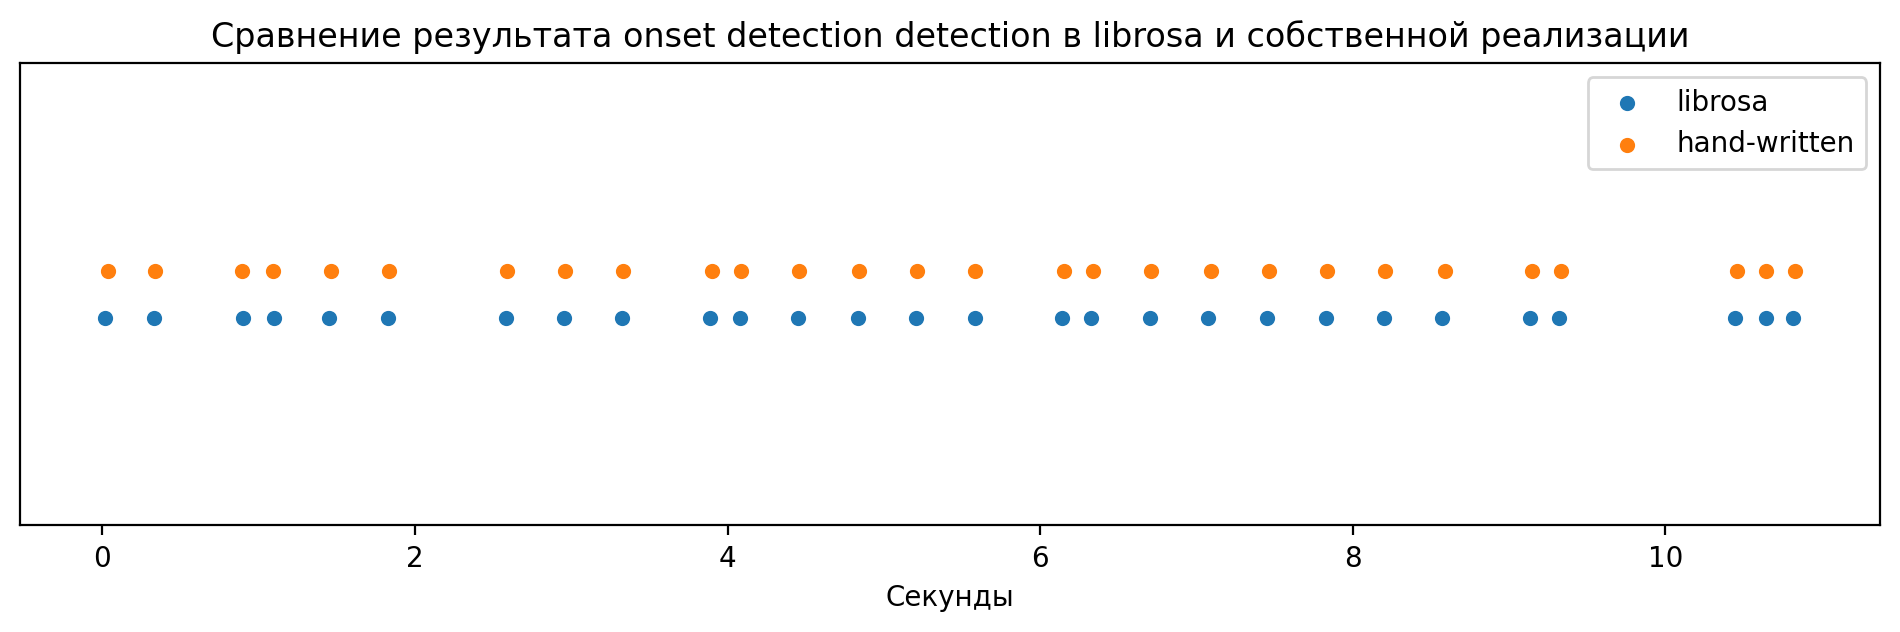

In [23]:
y_my = np.ones_like(my_time_onset)* 0.995
plt.subplots(1, 1, figsize=(12, 3))
y_librosa = np.ones_like(librosa_onset_times) * 1.005
alpha = 1
s = 20
plt.scatter(my_time_onset, y_my, alpha=alpha, s=s, label='librosa')
plt.scatter(librosa_onset_times, y_librosa, alpha=alpha, s=s, label='hand-written')
plt.ylim(0.95, 1.05)
plt.title('Сравнение результата onset detection detection в librosa и собственной реализации')
plt.legend()
plt.yticks([])
plt.xlabel('Секунды')

#### Tempo estimation

[BPM](https://ru.wikipedia.org/wiki/BPM_(%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B0)) (bpm, англ. beats per minute, удары в минуту) в музыке — показатель, определяющий скорость исполнения или воспроизведения композиции. BPM — это количество четвертных нот в минуту, например, 120 BPM означает, что в минуту играется 120 четвертных нот (следовательно, 2 четверти в секунду), или 120 четвертных ударов метронома в минуту.

Большинство произведений исполняется, записывается и воспроизводится в диапазоне от 30 до 240 BPM, более точные границы находятся в зависимости от жанра. Однако необходимо заметить, что скорость произведения зависит и от длительностей нoт; таким образом, целая нота со скоростью 120 BPM звучит быстрее, чем тридцать вторая со скоростью 2 BPM; верно и обратное — мелодия, написанная целыми нотами со скоростью 120 BPM, звучит медленнее, чем мелодия, написанная тридцать вторыми нотами, со скоростью 4 BPM. Таким образом, показатель BPM является относительным и скорость композиций сравнивать по нему имеет смысл только в близких жанрах со сходной договорённостью об использовании длительностей нот.

Документация: https://librosa.org/doc/0.8.1/generated/librosa.beat.tempo.html

In [24]:
tempo = librosa.beat.tempo(y=signal, sr=sr)
tempo

C:\Users\user\AppData\Local\Temp\ipykernel_4404\1000679977.py:1: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sr)


array([161.49902344])

#### Beat tracking

###### **Задание №3 (2 балла):** реализация Beat Tracking

Необходимо на основе информации onsets и tempo выделить ритмические конструкции. Общий порядок таков:
1. Расчитать разницу между onset-ами
2. На основе полученной разницы и заданного параметра min_beat, округляя, вычислить итоговую картину произведения, т.е. нужно перейти от абсолютных временных значений, к относительным, которые в дальнейшем будут переложены на ноты.

In [26]:
print(tempo[0])
tempo[0] = round(tempo[0])

161.4990234375


In [73]:
import numpy as np

def round_to_nearest_duration(diffs, durations):
    # Округляем разницы до ближайших стандартных длительностей
    nearest_durations = np.array([min(durations, key=lambda x: abs(x - diff)) for diff in diffs])
    return nearest_durations


def beats_tracking(onsets_s, tempo, min_beat=0.25):
    standard_durations = np.array([1, 1/2, 1/4 + 1/8, 1/4, 1/8 + 1/16, 1/8, 1/16, 0])
    
    beat_duration = 60.0 / tempo / min_beat

    onsets_diff = np.diff(onsets_s, prepend=onsets_s[0])

    note_durations = onsets_diff / beat_duration
    print(note_durations, "\n")

    rounded_durations = round_to_nearest_duration(note_durations, standard_durations)
    print(rounded_durations, "\n")

    rounded_durations = rounded_durations * (1/min_beat)

    return rounded_durations
# # 
# def beats_tracking(onsets_s, tempo, min_beat=0.25):
#     standard_durations = np.array([1, 1/2, 1/4 + 1/8, 1/4, 1/8 + 1/16, 1/8, 1/16, 0])
#     beat_duration = 60.0 / tempo # Получаем сколько длится 1/4 ноты
#     onsets_diff = np.diff(onsets_s)
#     note_durations = onsets_diff / beat_duration / 4 # Получаем сколько нот между онсетами
#     rounded_durations = round_to_nearest_duration(note_durations , standard_durations)
#     return rounded_durations 


beats = beats_tracking(my_time_onset, tempo[0])
beats

[0.         0.21165476 0.38047354 0.13325397 0.23937037 0.25184392
 0.50648677 0.2488168  0.24934921 0.37542328 0.13123082 0.25055093
 0.2533955  0.25080952 0.25147884 0.37511905 0.12350331 0.25491667
 0.24766071 0.25499272 0.25115939 0.25193519 0.24817791 0.3762295
 0.12659127 0.75372156 0.1344709  0.11346362] 

[0.     0.1875 0.375  0.125  0.25   0.25   0.5    0.25   0.25   0.375
 0.125  0.25   0.25   0.25   0.25   0.375  0.125  0.25   0.25   0.25
 0.25   0.25   0.25   0.375  0.125  1.     0.125  0.125 ] 


array([0.  , 0.75, 1.5 , 0.5 , 1.  , 1.  , 2.  , 1.  , 1.  , 1.5 , 0.5 ,
       1.  , 1.  , 1.  , 1.  , 1.5 , 0.5 , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.5 , 0.5 , 4.  , 0.5 , 0.5 ])

In [54]:
beat_duration = 60.0 / tempo
beat_duration

array([0.37267081])

In [55]:
onsets_diff = np.diff(librosa_onset_times, prepend=librosa_onset_times[0])
onsets_diff

array([0.        , 0.30185941, 0.55727891, 0.19736961, 0.37151927,
       0.37151927, 0.75464853, 0.37151927, 0.37151927, 0.56888889,
       0.18575964, 0.37151927, 0.38312925, 0.37151927, 0.37151927,
       0.56888889, 0.18575964, 0.37151927, 0.38312925, 0.37151927,
       0.37151927, 0.37151927, 0.38312925, 0.55727891, 0.18575964,
       1.1261678 , 0.18575964, 0.18575964])

#### Pitch detection

###### **Задание №4 (1 балл):** Применение функций оценки высот (pitch detection)

Выбираем лучший вариант из ЛР2

In [57]:
# ???
def estimate_pitch(frame, srate):
    correlation = np.correlate(frame, frame, mode='full')
    mid = len(correlation) // 2
    max_size = srate // 2
    slice = correlation[mid+1:mid+max_size+2]
    deltas = slice[1:] - slice[:-1]
    # find second
    argmax_index_after_mid = np.argmax((deltas[:-1] >= 0) & (deltas[1:] < 0))

    pitch = srate / argmax_index_after_mid
    return pitch


In [58]:
# Помощью ЛР1 или ЛР2 можете проиграть

In [59]:
def notes_recognize(signal, sr, onset_s):
  onset = np.concatenate([[int(elem*sr) for elem in onset_s], [len(signal)]])
  freqs = []
  for i in range(len(onset)):
        if i == len(onset) - 1:
            n = signal[onset[i] :]
        else:
            n = signal[onset[i] : onset[i + 1]]
        if list(n):
          freqs.append(estimate_pitch(n, sr))
  return freqs

notes = notes_recognize(signal, sr, my_time_onset)
notes

[165.78947368421052,
 531.3253012048193,
 531.3253012048193,
 531.3253012048193,
 531.3253012048193,
 531.3253012048193,
 501.1363636363636,
 501.1363636363636,
 537.8048780487804,
 658.2089552238806,
 531.3253012048193,
 501.1363636363636,
 501.1363636363636,
 531.3253012048193,
 474.19354838709677,
 450.0,
 450.0,
 450.0,
 454.63917525773195,
 450.0,
 450.0,
 531.3253012048193,
 595.9459459459459,
 747.457627118644,
 700.0,
 747.457627118644,
 747.457627118644,
 787.5]

#### Music Score Generation

In [60]:
def pitch(note_freq, diff_octave=0):
    A4 = 440
    C0 = A4 * np.power(2, -4.75)
    note_name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    h = int(np.round(12*np.log2(note_freq/C0)))
    octave = h // 12 + diff_octave
    n = h % 12
    return note_name[n] + str(octave)

Прежде чем пользоваться music21 скачай MuseScore 3-й версии. Более новые версии не подходят

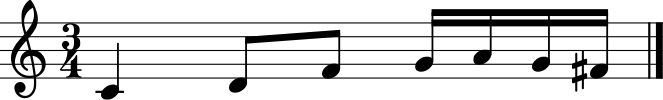

In [61]:
import music21 as m21
m21.environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe')
# Код для теста того, что все импортировалось верно
m21.converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#").show()

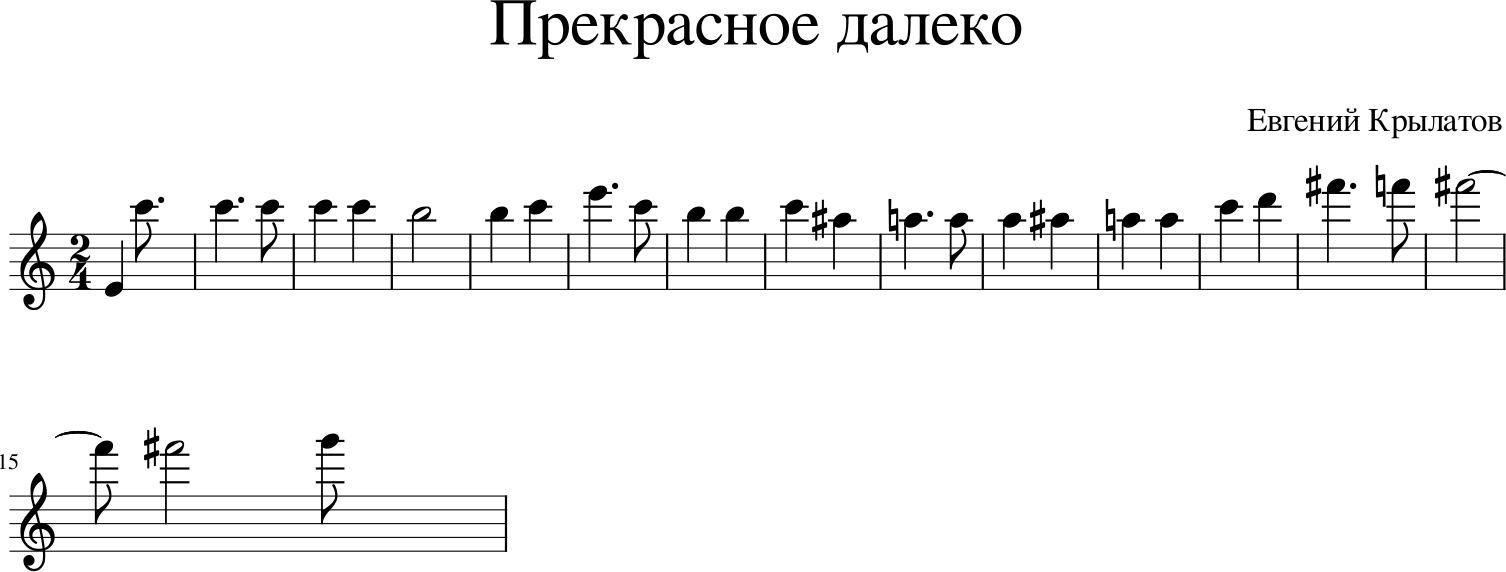

In [74]:



def generate_score(notes, beats, tempo, time_sig = '2/4', title='Unknown', composer='Unknown',
                   key=None, one_line=False, clef='Treble'):

    str2clef = {
        'Alto': m21.clef.AltoClef,
        'Bass': m21.clef.BassClef,
        'Treble': m21.clef.TrebleClef
    }

    clef21 = str2clef.get(clef, m21.clef.TrebleClef)()

    ts = m21.meter.TimeSignature(time_sig)
    n_measure = ts.denominator
    b_measure = ts.numerator

    staves = []
    current_staff = 0
    current_measure = 0
    b_cur = 0
    staves.append(m21.stream.Part())


    m = m21.stream.Measure([clef21])
    m.insert(0, ts)
    if key:
      m.insert(0, m21.key.Key(key))



    for i, (n, b) in enumerate(zip(notes, beats)):
        b_cur += b
        current_measure += b
        if current_measure > b_measure:
            staves[current_staff].append(m)
            m = m21.stream.Measure()
            current_measure = b
        if b_cur > n_measure * b_measure * (one_line * 10**8):
            #if i != len(notes) - 1:
            current_staff += 1
            staves.append(m21.stream.Part())
            if key:
              m.append(m21.key.Key(key))
            b_cur = b
        m.append(m21.note.Note(n, quarterLength = b))

    staves[current_staff].append(m)
    score = m21.stream.Score(staves)

    score.insert(0, m21.metadata.Metadata())
    score.metadata.title = title
    score.metadata.composer = composer
    score.show()
    if one_line:
      score.show('midi')

generate_score([pitch(freq, diff_octave=1) for freq in notes], beats, tempo[0], title='Прекрасное далеко', composer="Евгений Крылатов", key='C', one_line=True)#, clef='Bass')

### Генерация музыки

#### Генерация кавера для фортепиано

Полезные ссылки:

https://github.com/sweetcocoa/pop2piano/tree/main

https://colab.research.google.com/drive/1rBAs2TkryDnnQOhcM-mtlrgtL2h3ekml?usp=sharing

https://huggingface.co/docs/transformers/model_doc/pop2piano#transformers.Pop2PianoConfig

###### **Задание №5 (1 балл):** Исследование модели Pop2Piano.

Возьмите фрагмент попсовой песни на 20-30 секунд. Сгенерируйте три различных варианта пиано-кавера. Прослушайте. Сделайте выводы. Какой фрагмент вам понравился больше?


Для изменения генерации используйте параметр **composer** в методе **model.generate** (на выбор у вас есть composer1 - composer21)

In [ ]:
!pip install essentia==2.1b6.dev1034
!pip install pretty_midi==0.2.9
!pip install resampy

In [ ]:
import librosa
from IPython.display import Audio
from transformers import Pop2PianoForConditionalGeneration, Pop2PianoProcessor

name_file = "lady-gaga-bloody-mary.wav"
audio, sr = librosa.load(name_file, sr=44100)


model = Pop2PianoForConditionalGeneration.from_pretrained("sweetcocoa/pop2piano")
processor = Pop2PianoProcessor.from_pretrained("sweetcocoa/pop2piano")
inputs = processor(audio=audio, sampling_rate=sr, return_tensors="pt")
model_output = model.generate(input_features=inputs["input_features"], composer="composer3") # composer1 - 2 - 3 - 4 - 5 ... 21

tokenizer_output = processor.batch_decode(token_ids=model_output, feature_extractor_output=inputs)["pretty_midi_objects"][0]

midi_file = 'midi_result.mid'
tokenizer_output.write(midi_file)

Audio(audio, rate=sr)

Доп.задание на ресерч: поищеите другие способы озвучить midi (да, есть библиотеки и инструменты), чтобы звучало фортепиано, а не "гудки" синусоидальные

In [ ]:
!pip install midi-player


In [ ]:

from midi_player import MIDIPlayer
from midi_player.stylers import basic, cifka_advanced
sr=44100
MIDIPlayer(midi_file=midi_file, 500)

#### Генерация музыки по текстовому запросу

Полезные ссылки:

https://arxiv.org/abs/2306.05284

https://github.com/facebookresearch/audiocraft

https://huggingface.co/docs/transformers/model_doc/musicgen

###### **Задание №6 (1 балл):** Исследование модели Musicgen.

Сгенерируйте три фрагмента (по различным текстовым запросвм). Субъективно оцените, сделайте выводы. Поиграйтесь с параметрами **guidance_scale** и **max_new_tokens**, на что они влияют? (PS в документации тоже прописано :))

In [ ]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration

prompt = "Rock music of the 2000s with guitar and flute sounds"

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")
inputs = processor(
    text=[prompt],
    padding=True,
    return_tensors="pt",
)

audio_values = model.generate(**inputs, do_sample=True, guidance_scale=8, max_new_tokens=512)

In [ ]:
Audio(audio_values.numpy()[0], rate=sr)